**Taller 5**

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegFileWriter
from scipy.ndimage import generate_binary_structure
from scipy.ndimage import convolve
import pandas as pd
import re
from scipy.stats import gamma
from scipy.integrate import odeint
import time
from multiprocessing import Pool
import multiprocessing
if __name__ == "__main__":
    multiprocessing.set_start_method("spawn", force=True)

Punto 1


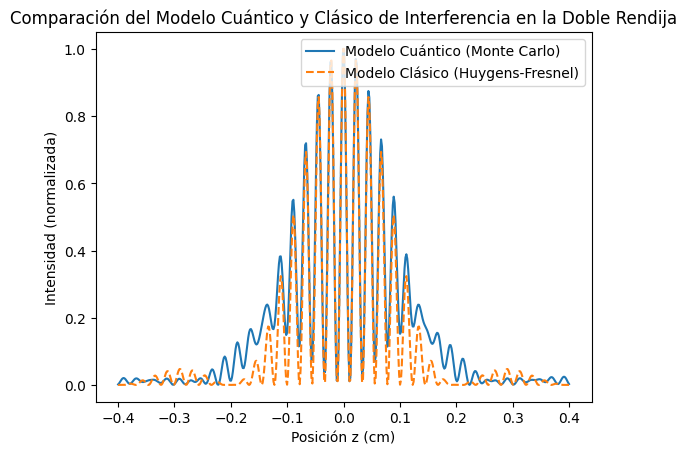

In [3]:
# Parámetros
lambda_ = 670e-9  # Longitud de onda (m)
A = 0.1e-2  # Ancho de apertura principal (m)
a = 0.01e-2  # Ancho de cada rendija (m)
d = 0.09e-2  # Separación entre las rendijas (m)
D1 = 0.3  # Distancia entre fuente y rendijas (m)
D2 = 0.3  # Distancia entre rendijas y pantalla (m)
N = 100000  # Número de muestras
z_vals = np.linspace(-0.4e-2, 0.4e-2, 500)  # Valores de z (m)

# Generación de muestras aleatorias
x_samples = np.random.uniform(-A/2, A/2, N)
y_samples = np.random.uniform(-d/2 - a/2, -d/2 + a/2, N//2)  # Primera rendija
y_samples = np.concatenate((y_samples, np.random.uniform(d/2 - a/2, d/2 + a/2, N//2)))  # Segunda rendija

# Cálculo de la intensidad cuántica
def quantum_intensity(z):
    phase = (2 * np.pi / lambda_) * (D1 + D2) + (np.pi / (lambda_ * D1)) * ((x_samples - y_samples)**2 + (z - y_samples)**2)
    integral = np.sum(np.exp(1j * phase))
    return np.abs(integral)**2

I_quantum = np.array([quantum_intensity(z) for z in z_vals])

# Normalización
I_quantum /= np.max(I_quantum)

# Cálculo del modelo clásico
theta_vals = np.arctan(z_vals / D2)
I_classic = (np.cos(np.pi * d / lambda_ * np.sin(theta_vals))**2) * (np.sinc(a / lambda_ * np.sin(theta_vals))**2)

# Normalización
I_classic /= np.max(I_classic)

# Gráfica
plt.plot(z_vals * 1e2, I_quantum, label='Modelo Cuántico (Monte Carlo)')
plt.plot(z_vals * 1e2, I_classic, label='Modelo Clásico (Huygens-Fresnel)', linestyle='--')
plt.xlabel('Posición z (cm)')
plt.ylabel('Intensidad (normalizada)')
plt.legend()
plt.title('Comparación del Modelo Cuántico y Clásico de Interferencia en la Doble Rendija')
plt.show()


Punto 2

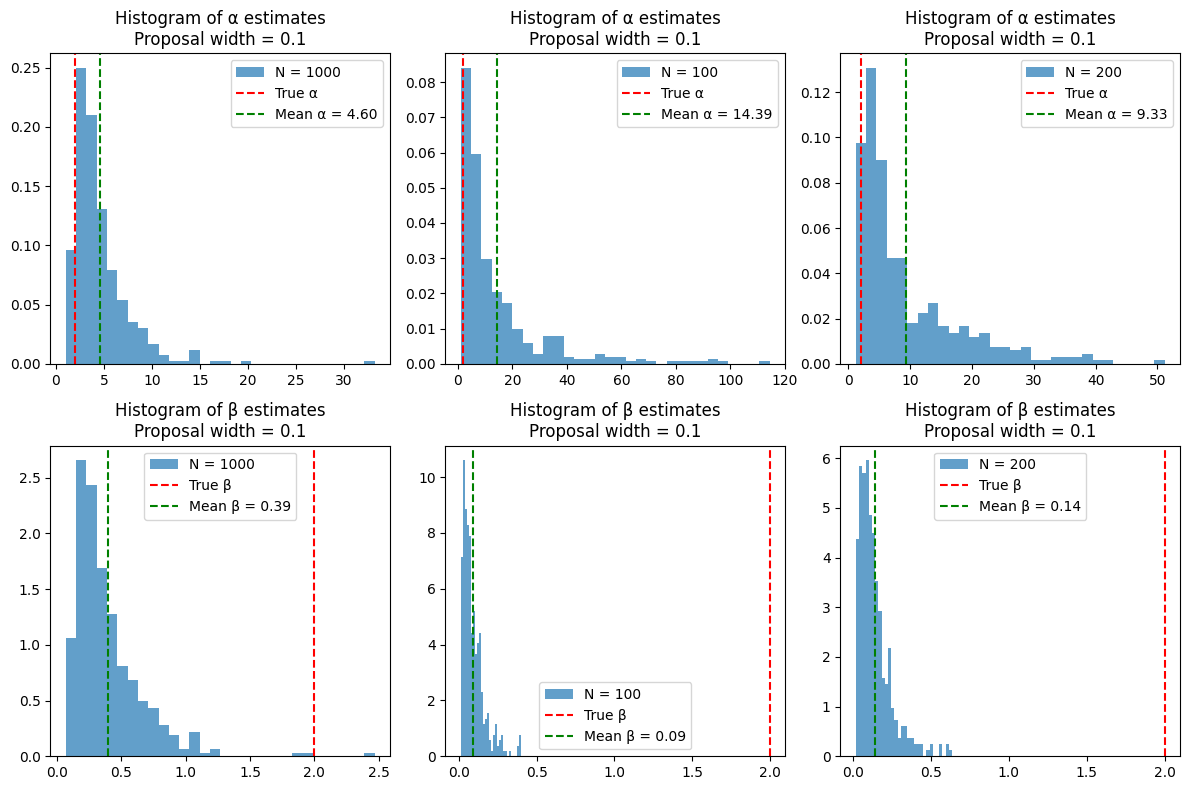

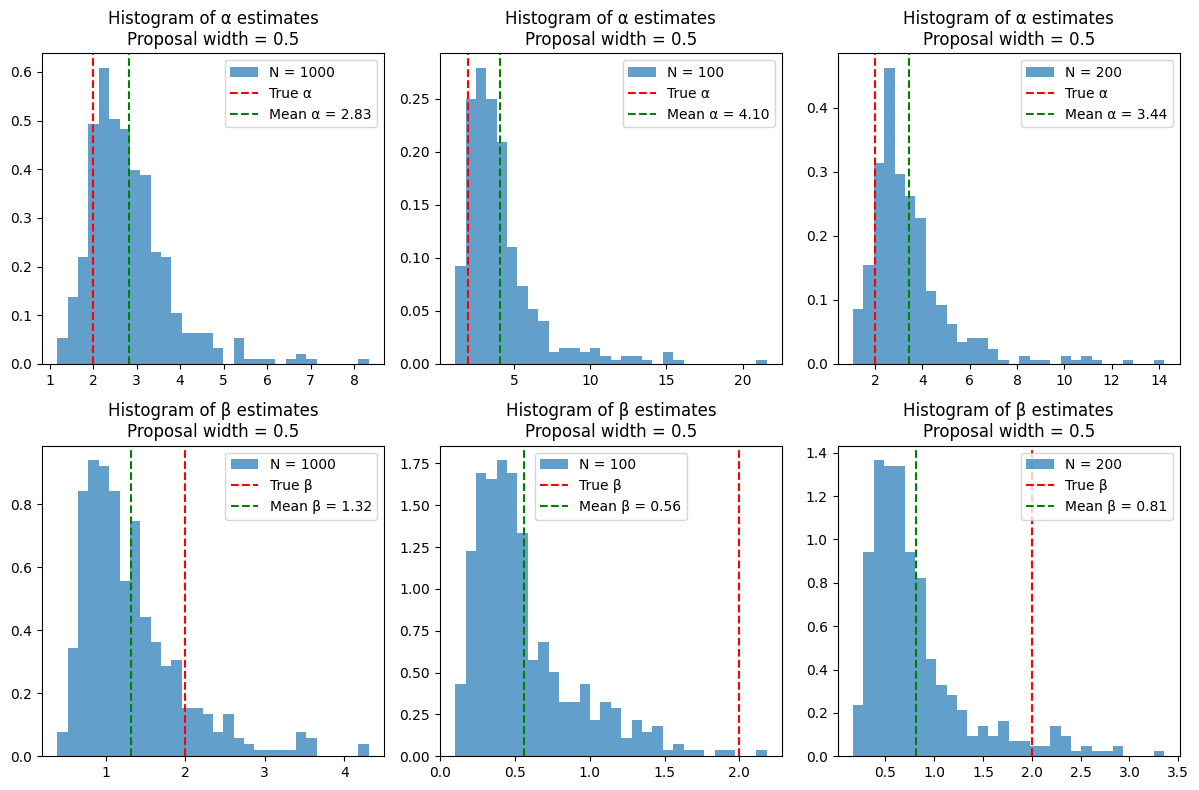

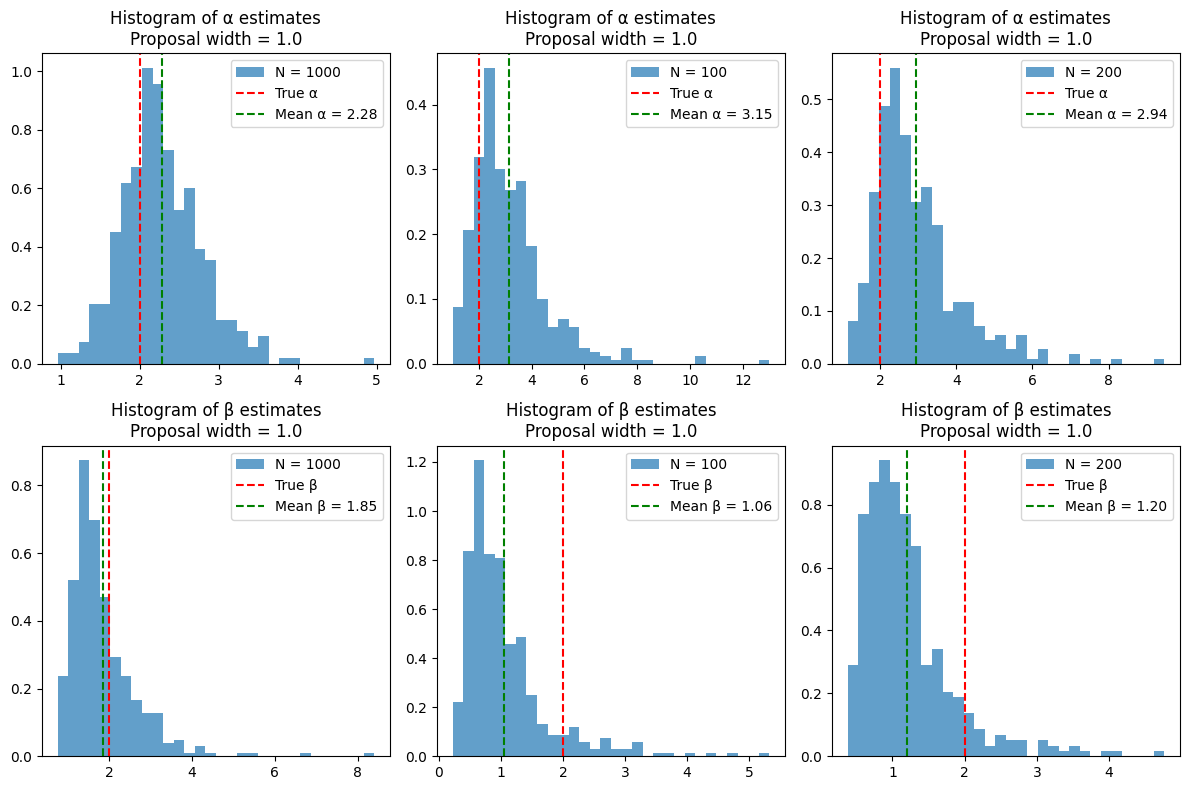

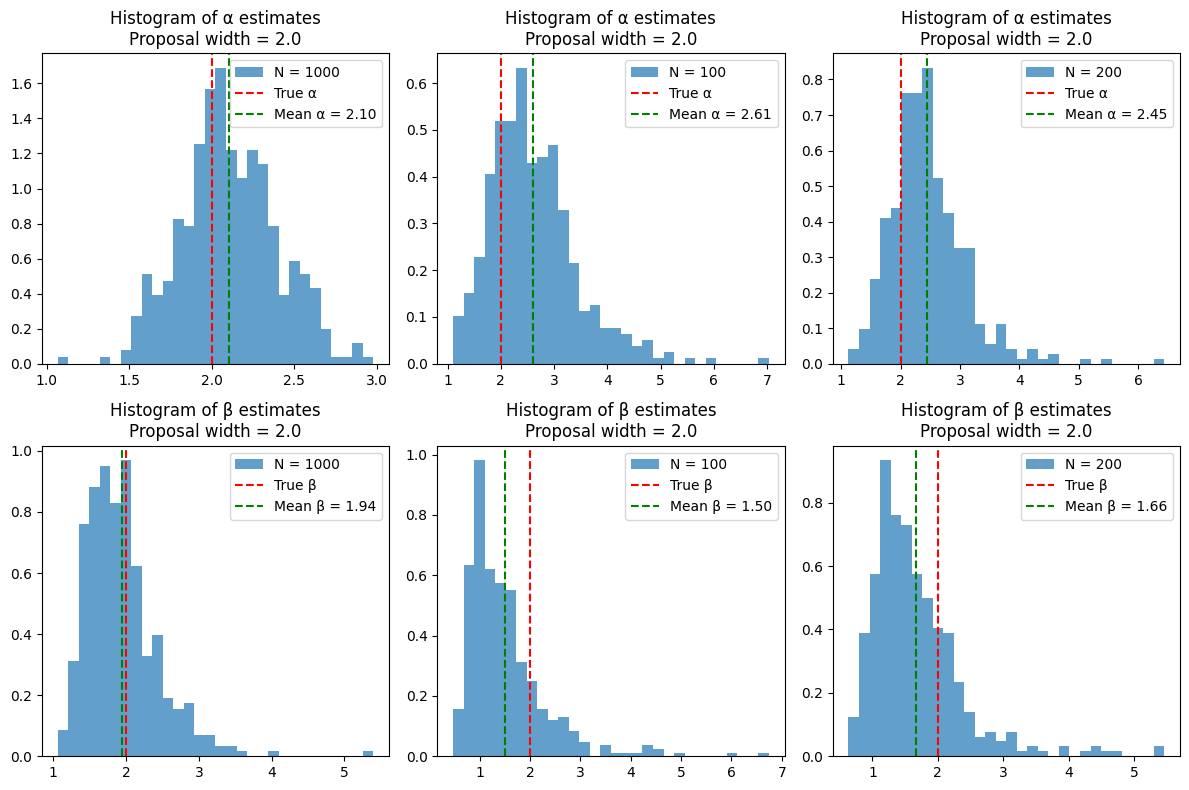

In [5]:
# Función Metrópolis-Hastings para la distribución Gamma
def metropolis_hastings(alpha, beta, N, proposal_width):
    samples = []
    x = np.random.rand()  # Valor inicial
    for _ in range(N):
        # Proponer un nuevo valor
        x_new = x + np.random.uniform(-proposal_width, proposal_width)
        if x_new > 0:  # Garantizar que x sea positivo para la distribución Gamma
            # Razón de aceptación
            acceptance_ratio = (x_new**(alpha-1) * np.exp(-x_new/beta)) / (x**(alpha-1) * np.exp(-x/beta))
            # Aceptar o rechazar
            if np.random.rand() < acceptance_ratio:
                x = x_new
        samples.append(x)
    return np.array(samples)

# Parámetros de la distribución Gamma
alpha, beta = 2.0, 2.0
N_values = [1000,100, 200]  # Diferentes números de muestras

# Pruebas con diferentes anchos de distribución de perturbación
proposal_widths = [0.1, 0.5, 1.0, 2.0]
fits_alpha = {w: {n: [] for n in N_values} for w in proposal_widths}
fits_beta = {w: {n: [] for n in N_values} for w in proposal_widths}

# Generar muestras y ajustar parámetros para cada ancho y valor de N
for proposal_width in proposal_widths:
    for N in N_values:
        for _ in range(400):  # Repetir 400 veces
            samples = metropolis_hastings(alpha, beta, N, proposal_width)
            fitted_alpha, loc, fitted_beta = gamma.fit(samples, floc=0)  # Ajustar los parámetros
            fits_alpha[proposal_width][N].append(fitted_alpha)
            fits_beta[proposal_width][N].append(fitted_beta)

# Graficar histogramas de los valores ajustados de α y β para diferentes N
for proposal_width in proposal_widths:
    plt.figure(figsize=(12, 8))

    # Graficar α
    for i, N in enumerate(N_values):
        plt.subplot(2, len(N_values), i + 1)
        plt.hist(fits_alpha[proposal_width][N], bins=30, density=True, alpha=0.7, label=f'N = {N}')
        plt.axvline(x=alpha, color='r', linestyle='--', label='True α')
        alpha_mean = np.mean(fits_alpha[proposal_width][N])
        plt.axvline(x=alpha_mean, color='g', linestyle='--', label=f'Mean α = {alpha_mean:.2f}')
        plt.title(f'Histogram of α estimates\nProposal width = {proposal_width}')
        plt.legend()

    # Graficar β
    for i, N in enumerate(N_values):
        plt.subplot(2, len(N_values), len(N_values) + i + 1)
        plt.hist(fits_beta[proposal_width][N], bins=30, density=True, alpha=0.7, label=f'N = {N}')
        plt.axvline(x=beta, color='r', linestyle='--', label='True β')
        beta_mean = np.mean(fits_beta[proposal_width][N])
        plt.axvline(x=beta_mean, color='g', linestyle='--', label=f'Mean β = {beta_mean:.2f}')
        plt.title(f'Histogram of β estimates\nProposal width = {proposal_width}')
        plt.legend()

    plt.tight_layout()
    plt.show()



Punto 3

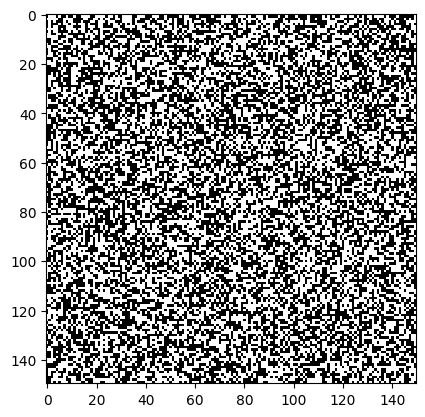

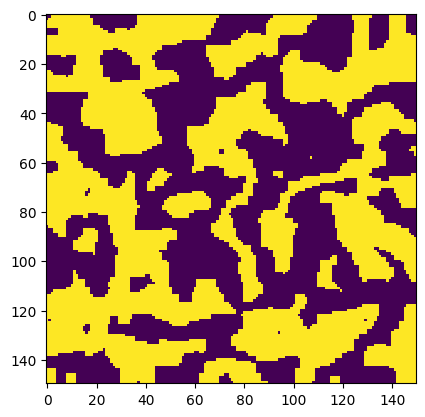

In [37]:
#Definir parametros
N = 150
J = 0.2
beta = 10

#Definir estado inicial del sistema
estado0 = np.random.randint(2, size=(N, N))
for i in range(len(estado0)):
    for j in range(len(estado0[i])):
        if estado0[i][j] == 0:
            estado0[i][j] = -1
#Muy ineficiente, solo prueba concepto, cambiar

#Calcular energia originial
def energia(array, J):
    kernel = generate_binary_structure(2, 1)
    kernel[1][1] = False
    resultado = -J * array * convolve(array, kernel, mode="constant", cval=0)
    return resultado.sum()

#Inicializar gráfico
metadata = dict(title="Muestra Solucíon Animada", artist="Yo")
writer = FFMpegFileWriter(fps=15, metadata=metadata)

fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(estado0, cmap="Greys",  interpolation="nearest")
plt.show()

def fun(estado0, J):
    for i in range(400000):
        #Calular energia inical
        Eo = energia(estado0, J)

        #Sacar posición aleatoria en el array
        rand = np.random.randint(N, size=(2))

        #Cambiar el valor de la posición
        estado1 = estado0.copy()
        estado1[rand[0], rand[1]] *= -1

        #Calcular la energia nueva
        En = energia(estado1, J)

        #Aplicar condiciones
        dE = En - Eo

        if dE <= 0 or np.random.random() < np.exp(-beta * dE):
            estado0 = estado1
    return estado1

plt.imshow(fun(estado0=estado0, J=J), interpolation="nearest")
plt.show()


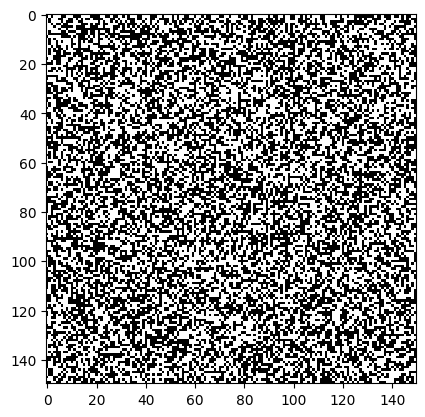

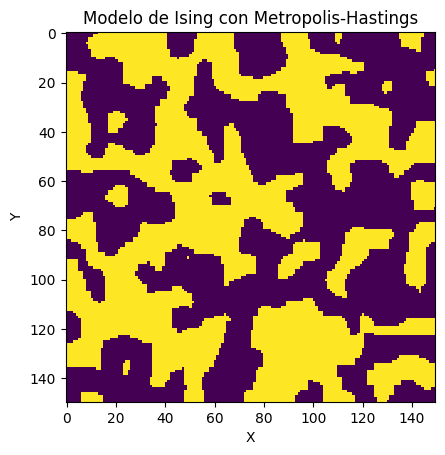

In [42]:
#Definir parametros
N = 150
J = 0.2
beta = 10

#Definir estado inicial del sistema
estado0 = np.random.randint(2, size=(N, N))
for i in range(len(estado0)):
    for j in range(len(estado0[i])):
        if estado0[i][j] == 0:
            estado0[i][j] = -1
#Muy ineficiente, solo prueba concepto, cambiar
plt.imshow(estado0, cmap="Greys",  interpolation="nearest")
plt.show()
#Calcular energia originial

def energia(array, J):
    kernel = generate_binary_structure(2, 1)
    kernel[1][1] = False
    resultado = -J * array * convolve(array, kernel, mode="constant", cval=0)
    return resultado.sum()

#Inicializar gráfico
metadata = dict(title="Muestra Solucíon Animada", artist="Yo")
writer = FFMpegFileWriter(fps=5, metadata=metadata)

fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(estado0, cmap="Greys",  interpolation="nearest")
ax.set_title("Modelo de Ising con Metropolis-Hastings")
ax.set_xlabel("X")
ax.set_ylabel("Y")

with writer.saving(fig, "Modelo Ising con Metropolis.mp4", 200):
    for i in range(600000):
        #Calular energia inical
        Eo = energia(estado0, J)

        #Sacar posición aleatoria en el array
        rand = np.random.randint(N, size=(2))

        #Cambiar el valor de la posición
        estado1 = estado0.copy()
        estado1[rand[0], rand[1]] *= -1

        #Calcular la energia nueva
        En = energia(estado1, J)

        #Aplicar condiciones
        dE = En - Eo

        if dE <= 0 or np.random.random() < np.exp(-beta * dE):
            estado0 = estado1

        if i % 10000 == 0:
            ax.imshow(estado1, interpolation="nearest")
            writer.grab_frame()


**AVISO**
Debido a problemas de compatibilidad, La animación se subio al repositorio como un archivo separado. Por favor dirigirse al archivo "Modelo Ising con Metropolis.mp4" para ver la animación correspondiente a este punto.

Punto 4

*4.1*

In [2]:
#Importar el Libro
with open("Alice in Wonderland.txt", "r", encoding="utf-8") as file:
    libro = file.read()

In [3]:
#Limpiar el libro
import re
libro_limpio = libro.replace("\r\n", "\n").replace("\n\n", "#").replace("\n", " ").replace("#", "\n\n")
libro_limpio = re.sub(r"[^\w\s.,;:?!\n]", "", libro_limpio)
libro_limpio = re.sub(r" {2,}", " ", libro_limpio)
libro_limpio = re.sub(r"ù", "u", libro_limpio)
libro_limpio = re.sub(r"_", "", libro_limpio)
libro_limpio = libro_limpio.lower()
#Quite la primera y ultima parte del libro a mano

#print(libro_limpio[:500])

*4.2*

In [34]:
#Declarar funciones de creacion de F y de generacion de texto
def crearF(book, n):
    #Parametros
    caracteres = sorted(set("abcdefghijklmnopqrstuvwxyz .,;:?!\n"))
    unicos = np.unique([book[i:i+n] for i in range(len(book)-n)]) #Me da las combinaciones unicas de n caracteres
    ngramas = []
    for i in unicos:
        ngramas.append(str(i))
    #print(ngramas)

    #Creando DataFrame
    F = pd.DataFrame(np.zeros((len(ngramas), len(caracteres)), dtype=int), index=ngramas, columns=caracteres)

    for i in range(len(book) - n):
        posicion = book[i:i+n]
        posicion_sig = book[i+n]
        #if posicion in ngramas and posicion_sig in caracteres:
        #print(posicion, posicion_sig)
        F.loc[posicion, posicion_sig] += 1

    return F

"""""if __name__ == "__main__":

    chunk_size = len(libro_limpio) // 4
    libro_chunks = [libro_limpio[i:i + chunk_size] for i in range(0, len(libro_limpio), chunk_size)]

    with Pool() as p:
        results = p.map(crearF, libro_chunks)
    F = sum(results)
    print(F)"""""

#F = crearF(libro_limpio, n=n)

#P = F / F.sum(axis=1).values[:,None]

#Generar texto
def gen_texto(n, P, m=1500):

    n_grams_enter = [n_grama for n_grama in P.index if n_grama.startswith('\n')]
    start = np.random.choice(n_grams_enter)

    texto_generado = start

    for _ in range(m - n):
        ultimas_letras = texto_generado[-n:]

        if ultimas_letras in P.index:
            siguiente_char = np.random.choice(P.columns, p=P.loc[ultimas_letras].values)
        else:
            siguiente_char = np.random.choice(P.columns)

        texto_generado += siguiente_char

    return texto_generado


*4.3*

In [43]:
#Generar textos con diferentes valores de n
x = ""
for i in range(1,9):

    F = crearF(libro_limpio, n=i)

    P = F / F.sum(axis=1).values[:,None]

    x += f"Texto generado con valor de n = {i}:\n{gen_texto(n=i, P=P)}\n==================================================================================================================================================================================================\n"

with open('textos_generados.txt', 'w+') as fh:
    fh.write(x)


**AVISO**
El texto generado se guardo en un archivo separado dentro del repositorio. Por favor dirigirse al archivo "textos_generados.txt" para visualizarlos.

Nos parece que para obtener texto que tenga un parecido significativo con el idioma ingles, se necesita de un n >= 6.

In [48]:
#Importar las palabras del idioma ingles
with open("words_alpha.txt", "r", encoding="utf-8") as file:
    words = file.read()

#Crear texto con n=6
F = crearF(libro_limpio, n=6)

P = F / F.sum(axis=1).values[:,None]

x = f"Texto generado con valor de n = 6:\n{gen_texto(n=6, P=P)}"

palabras = re.split(r'\W+', x)
    
palabras = [word.lower() for word in x if word]

counter = 0
for i in palabras:
    if i in words:
        counter += 1

porcentaje = 100*counter/len(palabras)

print(f"El porcentaje de palabras generadas para n=6 que pertenecen realmente al ingles es de {round(porcentaje,2)}%")

El porcentaje de palabras generadas para n=6 que pertenecen realmente al ingles es de 77.98%


Extra:

¿Depende esto del libro usado para entrenar el modelo?
¿del género del libro (novela, poesía, ensayo, etc)
¿del lenguaje del libro?

Dado que un solo libro constituye una fuente relativamente pequeña y potencialmente sesgada de texto, es probable que se puedan identificar características específicas que revelen el origen del libro utilizado. Por ejemplo, en nuestro modelo empleamos la obra Alice in Wonderland. Como resultado, durante la generación de texto era común observar el nombre "Alice", ya que se repite constantemente a lo largo de la narrativa. Sin embargo, este tipo de modelos pueden funcionar con cualquier obra literaria, independientemente del género, autor o incluso del idioma. Esto se debe a la forma en que operan los lenguajes humanos.

La frecuencia con la que se repiten las palabras más comunes sigue un patrón definido. Este fenómeno se describe mediante la Ley de Zipf, la cual establece que en un corpus textual de cualquier idioma, la frecuencia de una palabra es inversamente proporcional a su posición en una lista ordenada de acuerdo con su frecuencia. Es decir:


$f(r) \propto \frac{1}{r}$

donde:

$f(r)$ es la frecuencia de la palabra.

$r$ es el rango o la posición de la palabra cuando se ordenan de mayor a menor frecuencia.

Gracias a este principio, sin importar el texto o el autor, la distribución de las palabras más comunes tiende a mantenerse constante. En consecuencia, utilizando algoritmos como el aplicado en este taller, es posible identificar dichas palabras (o caracteres) más recurrentes y calcular la probabilidad de que una determinada palabra o carácter suceda a otro.

¿qué pasos habría que seguir para que este modelo pudiera mantener
una conversación, o producir frases gramaticalmente correctas?

Para que un modelo de lenguaje pueda cumplir una función específica, es necesario entrenarlo de manera acorde con la tarea. Por lo tanto, si deseamos que el modelo sea capaz de responder preguntas, debemos entrenarlo utilizando un corpus que contenga una amplia variedad de preguntas y respuestas. Para este propósito, las redes sociales son una excelente fuente de datos. Plataformas como Quora o Reddit se basan en la interacción entre usuarios que plantean preguntas y otros que proporcionan respuestas. Al entrenar nuestro modelo con grandes volúmenes de texto provenientes de estas plataformas, se logra que adquiera la capacidad de responder preguntas de manera fluida y natural.

Punto 5

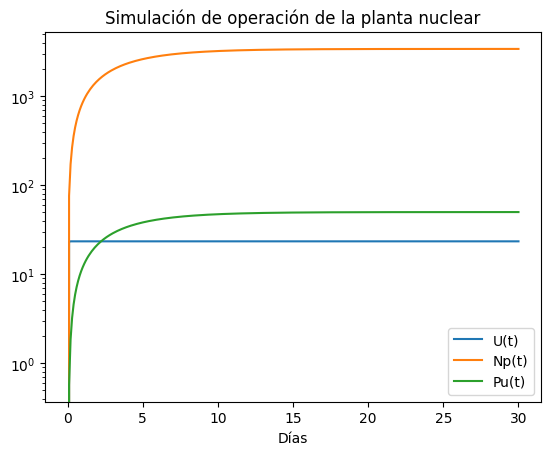

No se alcanzó un estado estable durante la simulación.


In [49]:
# Parámetros del problema
A = 1000  # Producción diaria de U239
B = 20    # Extracción diaria de Pu239
t_half_U = 23.4 / (24 * 60)  # Vida media de U239 en días
t_half_Np = 2.36  # Vida media de Np239 en días

# Constantes de decaimiento (lambda)
lambda_U = np.log(2) / t_half_U
lambda_Np = np.log(2) / t_half_Np

# Tiempo de simulación en días
days = 30
t = np.linspace(0, days, 300)  # Puntos de tiempo en días

# Sistema de ecuaciones diferenciales
def sistema(y, t, A, lambda_U, lambda_Np, B):
    U, Np, Pu = y
    dU_dt = A - lambda_U * U
    dNp_dt = lambda_U * U - lambda_Np * Np
    dPu_dt = lambda_Np * Np - B * Pu
    return [dU_dt, dNp_dt, dPu_dt]

# Condiciones iniciales (Planta completamente limpia)
y0 = [0, 0, 0]

# Solución del sistema de ecuaciones
sol = odeint(sistema, y0, t, args=(A, lambda_U, lambda_Np, B))

# Extraer las soluciones para U, Np, y Pu
U = sol[:, 0]
Np = sol[:, 1]
Pu = sol[:, 2]

# Graficar resultados
plt.plot(t, U, label="U(t)")
plt.plot(t, Np, label="Np(t)")
plt.plot(t, Pu, label="Pu(t)")
plt.yscale('log')  # Escala logarítmica en el eje Y
plt.xlabel('Días')
plt.legend()
plt.title('Simulación de operación de la planta nuclear')
plt.show()

# Detección de estado estable
tolerancia = 1e-3  # Tolerancia para la comparación
estado_estable_dias = None
for i in range(1, len(t)):
    if abs(U[i] - U[i-1]) < tolerancia and abs(Np[i] - Np[i-1]) < tolerancia and abs(Pu[i] - Pu[i-1]) < tolerancia:
        estado_estable_dias = t[i]
        print(f"Estado estable alcanzado en {estado_estable_dias:.2f} días")
        break

if estado_estable_dias is None:
    print("No se alcanzó un estado estable durante la simulación.")


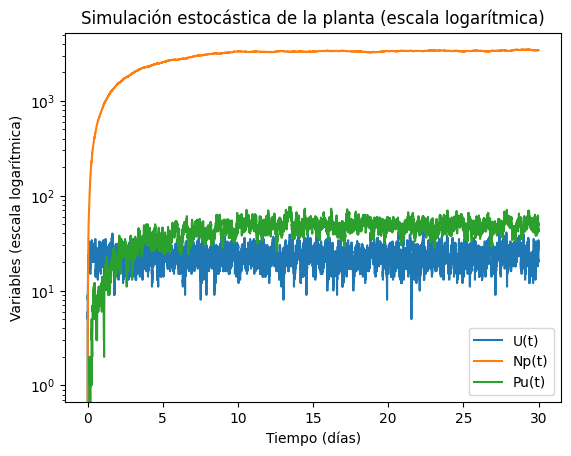

In [50]:
# Parámetros del problema
A = 1000         # Tasa de introducción de U
B = 20           # Tasa de eliminación de Pu

# Constantes de decaimiento
t_half_U = 23.4 / 1440  # Vida media de U (en días), 23.4 min = 23.4 / 1440 días
t_half_Np = 2.36        # Vida media de Np (en días)

lambda_U = np.log(2) / t_half_U  # Tasa de reacción U -> Np
lambda_Np = np.log(2) / t_half_Np  # Tasa de reacción Np -> Pu

time_limit = 30  # Simulación por 30 días

# Vectores de cambio de estado R
R = np.array([[1, 0, 0],   # Evento 1: Introducción de U
              [-1, 1, 0],  # Evento 2: U -> Np
              [0, -1, 1],  # Evento 3: Np -> Pu
              [0, 0, -1]]) # Evento 4: Eliminación de Pu

# Condiciones iniciales
Y = np.array([0, 0, 0])  # [U, Np, Pu] iniciales
t = 0  # Tiempo inicial

# Historial para graficar
time_history = [t]
U_history = [Y[0]]
Np_history = [Y[1]]
Pu_history = [Y[2]]

# Simulación estocástica
while t < time_limit:
    # Calcular las tasas actuales
    Tasas = np.array([A, lambda_U * Y[0], lambda_Np * Y[1], B * Y[2]])
    total_rate = np.sum(Tasas)

    if total_rate == 0:
        break  # No hay más eventos posibles

    # Tiempo hasta la siguiente reacción
    tau = np.random.exponential(1 / total_rate)

    # Elegir la reacción según las probabilidades
    probabilities = Tasas / total_rate
    reaction = np.random.choice(len(R), p=probabilities)

    # Aplicar la reacción al estado del sistema
    Y += R[reaction]

    # Asegurarse de que los valores no sean negativos
    Y = np.maximum(Y, 0)

    # Evolucionar el tiempo
    t += tau

    # Guardar el estado actual del sistema
    time_history.append(t)
    U_history.append(Y[0])
    Np_history.append(Y[1])
    Pu_history.append(Y[2])

# Graficar los resultados en escala logarítmica
plt.plot(time_history, U_history, label='U(t)')
plt.plot(time_history, Np_history, label='Np(t)')
plt.plot(time_history, Pu_history, label='Pu(t)')
plt.yscale('log')
plt.xlabel('Tiempo (días)')
plt.ylabel('Variables (escala logarítmica)')
plt.legend()
plt.title('Simulación estocástica de la planta (escala logarítmica)')
plt.show()

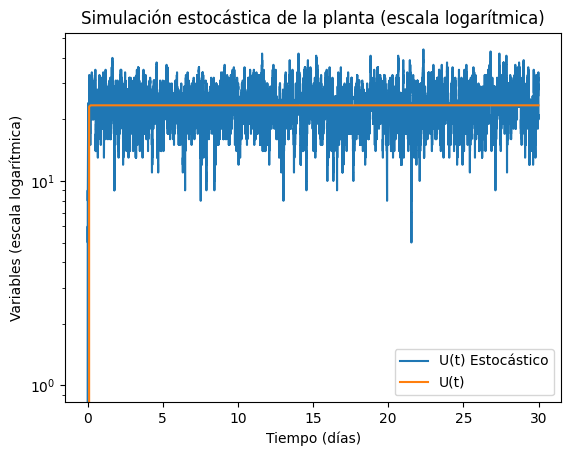

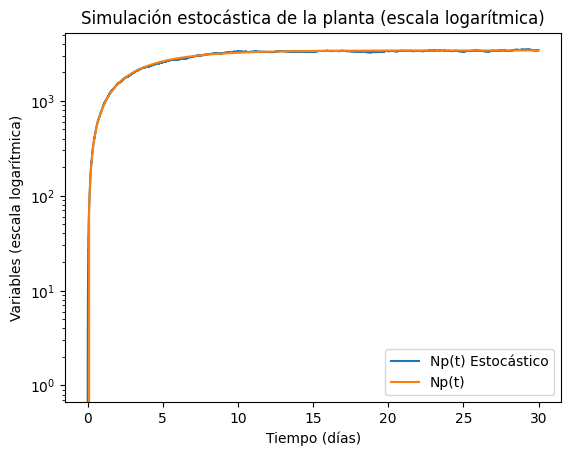

Text(0.5, 1.0, 'Simulación estocástica de la planta (escala logarítmica)')

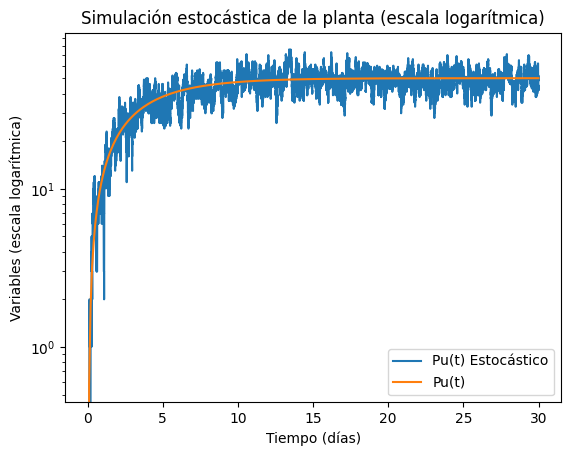

In [55]:
days = 30
t = np.linspace(0, days, 300)  # Puntos de tiempo en días

plt.plot(time_history, U_history, label='U(t) Estocástico')
plt.plot(t, U, label="U(t)")
plt.yscale('log')
plt.xlabel('Tiempo (días)')
plt.ylabel('Variables (escala logarítmica)')
plt.legend()
plt.title('Simulación estocástica de la planta (escala logarítmica)')
plt.show()

plt.plot(time_history, Np_history, label='Np(t) Estocástico')
plt.plot(t, Np, label="Np(t)")
plt.yscale('log')
plt.xlabel('Tiempo (días)')
plt.ylabel('Variables (escala logarítmica)')
plt.legend()
plt.title('Simulación estocástica de la planta (escala logarítmica)')

plt.show()
plt.plot(time_history, Pu_history, label='Pu(t) Estocástico')
plt.plot(t, Pu, label="Pu(t)")
plt.yscale('log')
plt.xlabel('Tiempo (días)')
plt.ylabel('Variables (escala logarítmica)')
plt.legend()
plt.title('Simulación estocástica de la planta (escala logarítmica)')


In [11]:
# Función para realizar la simulación estocástica
def simular(A, B, lambda_U, lambda_Np, time_limit):
    # Vectores de cambio de estado R
    R = np.array([[1, 0, 0],   # Evento 1: Introducción de U
                  [-1, 1, 0],  # Evento 2: U -> Np
                  [0, -1, 1],  # Evento 3: Np -> Pu
                  [0, 0, -1]]) # Evento 4: Eliminación de Pu

    # Condiciones iniciales
    Y = np.array([0, 0, 0])  # [U, Np, Pu] iniciales
    t = 0  # Tiempo inicial

    # Simulación estocástica
    while t < time_limit:
        # Calcular las tasas actuales
        Tasas = np.array([A, lambda_U * Y[0], lambda_Np * Y[1], B * Y[2]])
        total_rate = np.sum(Tasas)

        if total_rate == 0:
            break  # No hay más eventos posibles

        # Tiempo hasta la siguiente reacción
        tau = np.random.exponential(1 / total_rate)

        # Elegir la reacción según las probabilidades
        probabilities = Tasas / total_rate
        reaction = np.random.choice(len(R), p=probabilities)

        # Aplicar la reacción al estado del sistema
        Y += R[reaction]

        # Asegurarse de que los valores no sean negativos
        Y = np.maximum(Y, 0)

        # Evolucionar el tiempo
        t += tau

        # Verificar si Pu alcanza o supera 80
        if Y[2] >= 80:
            return True  # Se alcanzó el umbral de Pu
    return False  # No se alcanzó el umbral de Pu

num_simulaciones = 100

# Contador de simulaciones exitosas (Pu >= 80)
contador_exitos = 0

# Ejecutar múltiples simulaciones
for _ in range(num_simulaciones):
    if simular(A, B, lambda_U, lambda_Np, time_limit):
        contador_exitos += 1

# Calcular la probabilidad
probabilidad = contador_exitos / num_simulaciones

# Mostrar el resultado
print(f"La probabilidad de que el nivel de Pu llegue a ser igual o mayor a 80 es {probabilidad:.4f}")

La probabilidad de que el nivel de Pu llegue a ser igual o mayor a 80 es 0.1800
